# Benchmarking different sparse matrix formats
In this notebook I am running some time tests for `coo_matrix` and compare it to the `csr_matrix` I am familiar with. The former allows you to pass the matrix elements, along with their row and column indices and generate a sparse matrix. In the latter method, I will make a dense matrix first and then convert it into sparse using `csr_matrix`- I am interested in finding out if there is a large overhead associated with this step.

In [1]:
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
from scipy import sparse

%matplotlib widget
# Timing decorator :
import time                                                
def timeit(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        print( '%r (%r, %r) % sec' % \
              (method.__name__, args, kw, te-ts))
        return te - ts

    return timed

### Test matrix
Let the test matrix be $M_{ij}$ of shape $(100 , 100)$. The non-zero elements are:
$$\begin{align*} M_{12} &= 1 \\ M_{40 , 50} &= 2 \\ M_{2 , 7} &= 3 \\ M_{81 , 33} &= 4 \\ M_{56 , 70} &= 5\end{align*}$$
These elements were chosen randomly.

In [2]:
# Dimensions of test matrix:
N = 100
@timeit
def make_matrix(N):
    m =  np.zeros(shape = (N, N))
    m[1 , 2] = 1
    m[40 , 50] = 2
    m[2 , 7] = 3
    m[81 , 33] = 4
    m[56 , 70] = 5
    return m

test_matrix = make_matrix(N)

'make_matrix' ((100,), {}) 2.09808349609375e-05ec


Tiime associated with making the numpy matrix is practically negligible.Now let's use `csr_matrix`:

In [3]:
ts = time.time()
tm_csr = csr_matrix(test_matrix)
te = time.time()
print(te - ts)

0.0027570724487304688


Now let's make the same matrix using `coo_matrix`. Here's how the syntax works: You need to give it three arrays. The first is an array of row indices:
$$ \mathbf{v}_{rows} = (1 , 40 , 2 , 81 , 56)^{T} $$
The second is an array of column indices:
$$ \mathbf{v}_{columns} = (2 , 50 , 7 , 33 , 70)^{T} $$
The last is an array of matrix elements:
$$ \mathbf{v}_{elements} = (M_{1 , 2} , M_{40  , 50} , M_{81 , 33} , M_{56 , 70})^{T} $$

In [4]:
row_indices = np.array([1 , 40 , 2 , 81 , 56 ])
column_indices = np.array([2 , 50 , 7 , 33 , 70 ])
element_values = np.array([1, 2 , 3 ,4 , 5])
ts = time.time()
tm_coo = coo_matrix((element_values , (row_indices , column_indices)) , shape = (N , N))
te = time.time()
print(te - ts)

0.00019216537475585938


Looks like it's an order of magnitude smaller! Let's make these two into functions and see what happens when N we make N larger.

In [5]:
@timeit
def make_matrix_csr(N):
    m =  np.zeros(shape = (N, N))
    m[1 , 2] = 1
    m[40 , 50] = 2
    m[2 , 7] = 3
    m[81 , 33] = 4
    m[56 , 70] = 5
    csr_matrix(m)

@timeit
def make_matrix_coo(N):
    row_indices = np.array([1 , 40 , 2 , 81 , 56 ])
    column_indices = np.array([2 , 50 , 7 , 33 , 70 ])
    element_values = np.array([1, 2 , 3 ,4 , 5])
    coo_matrix((element_values , (row_indices , column_indices)) , shape = (N , N))

@timeit
def make_matrix_csr_but_spicy(N):
    row_indices = np.array([1 , 40 , 2 , 81 , 56 ])
    column_indices = np.array([2 , 50 , 7 , 33 , 70 ])
    element_values = np.array([1, 2 , 3 ,4 , 5])
    csr_matrix((element_values , (row_indices , column_indices)) , shape = (N , N))

time_csr = make_matrix_csr(10000)
time_coo = make_matrix_coo(10000)
time_csr_spicy = make_matrix_csr_but_spicy(10000)
print(time_csr)
print(time_coo)
print(time_csr_spicy)

'make_matrix_csr' ((10000,), {}) 1.3675687313079834ec
'make_matrix_coo' ((10000,), {}) 0.00018310546875ec
'make_matrix_csr_but_spicy' ((10000,), {}) 0.001657247543334961ec
1.3675687313079834
0.00018310546875
0.001657247543334961


`coo_matrix` seems wayyy faster! Let's also do some benchmarking for the time difference as you increase the size of the matrix. 

In [6]:
n_values = np.array([100 , 1000 , 10000 , 20000 , 30000])
csr_times = []
coo_times = []
spicy_times = []
from tqdm import tqdm
for n in tqdm(n_values):
    csr_times.append(make_matrix_csr(n))
    coo_times.append(make_matrix_coo(n))
    spicy_times.append(make_matrix_csr_but_spicy(n))

  0%|          | 0/5 [00:00<?, ?it/s]

'make_matrix_csr' ((100,), {}) 0.0018680095672607422ec
'make_matrix_coo' ((100,), {}) 0.0001990795135498047ec
'make_matrix_csr_but_spicy' ((100,), {}) 0.0004780292510986328ec
'make_matrix_csr' ((1000,), {}) 0.013680219650268555ec
'make_matrix_coo' ((1000,), {}) 8.869171142578125e-05ec
'make_matrix_csr_but_spicy' ((1000,), {}) 0.0003478527069091797ec


 60%|██████    | 3/5 [00:01<00:00,  2.40it/s]

'make_matrix_csr' ((10000,), {}) 1.2298598289489746ec
'make_matrix_coo' ((10000,), {}) 0.00021600723266601562ec
'make_matrix_csr_but_spicy' ((10000,), {}) 0.00030803680419921875ec


 80%|████████  | 4/5 [00:08<00:02,  2.51s/it]

'make_matrix_csr' ((20000,), {}) 6.901252746582031ec
'make_matrix_coo' ((20000,), {}) 0.00017309188842773438ec
'make_matrix_csr_but_spicy' ((20000,), {}) 0.0002980232238769531ec


100%|██████████| 5/5 [00:22<00:00,  4.57s/it]

'make_matrix_csr' ((30000,), {}) 14.692556142807007ec
'make_matrix_coo' ((30000,), {}) 0.00021195411682128906ec
'make_matrix_csr_but_spicy' ((30000,), {}) 0.00028586387634277344ec


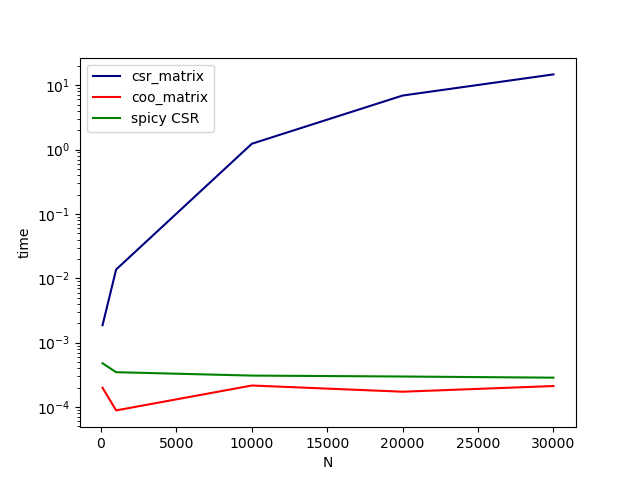

In [7]:
import matplotlib.pyplot as plt
fig , ax = plt.subplots()
ax.semilogy(n_values , csr_times , color = 'navy' , label = 'csr_matrix')
ax.semilogy(n_values , coo_times , color = 'r' , label = 'coo_matrix')
ax.semilogy(n_values , spicy_times , color = 'g' , label = 'spicy CSR')
ax.set_ylabel('time')
ax.set_xlabel(r'N')
ax.legend()


Aha, so for this simple test case `coo_matrix` wins! I guess this kind of makes sense, because the inputs to the coo_matrix are those elements which are non-zero, and they never change. I'm not sure how `csr_matrix` works under the hood, but the function recieves a dense matrix with only a few nonzero elements. Somehow it has to search for all these nonzero elements and record their positions before it can represent the matrix in sparse format, which sounds quite costly for large matrix sizes. <br>
Looking at the times more closely, as $N$ increases by a factor $10^{4}$ , so does $T_{CSR}$ (roughly). Maybe this suggests that the underlying algorithm has complexity $\mathcal{O}(N)$? <br>
Also you may have noticed I tried something called "spicy CSR". This is similar to `coo_matrix` in the sense that you just pass it matrix values and indices, except it uses the Compressed Sparse Row format. It still seems to lose to `coo_matrix`

### A more realistic test case

That was quite an artifical test case. I want to try generating matrices with richer/banded structure, since this would be more similar to what we have in the `skyrmpy_function` module. The specific function I am looking at is the `H_matrix` function.<br>
In a system with $N\times N$ sites, the length of a state-vector $|\mathbf{v}\rangle$ is $3 N^{2}$, because each site has a 3 component vector. `H_matrix` returns a matrix $\mathbb{H}$ such that:
$$ \mathbb{H}|\mathbf{v}\rangle = \mathbf{H}_{ij} \times \mathbf{m}_{ij} $$
We also need a bunch of test values for $\mathbf{H}_{ij}$ because cba to generate a realistic set of demagnetisation fields...

In [8]:
@timeit
def H_matrix_csr(N , h):
    """ 
    This is practically identical to the H_matrix function.
    h is meant to be a test array which gives the value of the local demagnetisation fields at each lattic point. 
    I'm gonna stick to a simple array like h = np.arange(3*N**2)
    """
    H = np.zeros(shape = (3*N**2 , 3*N**2))
    n = 0
    count = 0
    for i in range(N):
        for j in range(N):
            # Local demagnetisation field vector:
            H_ij = h[3*count : 3*count + 3]
            # Turning vector into a cross product matrix:
            H[n , n+1] = -1*H_ij[2]
            H[n , n+2] = H_ij[1]
            H[n+1 , n+2] = -1*H_ij[0]
        
            H[n+1 , n] = -1* H[n , n+1]
            H[n+2 , n] = -1* H[n , n+2]
            H[n+2 , n+1] = -1* H[n+1 , n+2]
            n += 3 
            count +=1
    H_sp = csr_matrix(H)
    return H_sp

@timeit
def H_matrix_coo(N , h):
    """ 
    Generating the H_matrix using coo_matrix.
    h is meant to be a test array which gives the value of the local demagnetisation fields at each lattic point. 
    I'm gonna stick to a simple array like h = np.arange(3*N**2).
    """
    
    # This bit generates the arrays that hold the row and column indices. Technically, this is something that can
    # be generated outside the function once so that it isn't called every time-step:
    displacement_array = np.repeat(np.arange(3*N**2 , step = 3) , 3)
    monomer1 = np.array([0 , 0 , 1])
    monomer2 = np.array([1 , 2 , 2])
    polymer1 = np.tile(monomer1 , N**2)
    polymer2 = np.tile(monomer2 , N**2)

    rows = polymer1 + displacement_array
    columns = polymer2  + displacement_array

    block = np.array([[0,0,-1],[0 , 1 , 0],[-1  , 0 , 0]])
    # Shuffling around elements of h, so that the resulting matrix has the correct cross product structure
    h_shuffled = sparse.kron(sparse.identity(N**2) , block)@h

    return coo_matrix((h_shuffled , (rows , columns)), shape = (3*N**2 , 3*N**2)) - coo_matrix((h_shuffled , (columns , rows)), shape = (3*N**2 , 3*N**2))

    

In [9]:
n = 100
h = np.arange(3*n**2)
time_Hcsr = H_matrix_csr(n , h)
time_Hcoo = H_matrix_coo(n , h)
print(time_Hcsr , time_Hcoo)

'H_matrix_csr' ((100, array([    0,     1,     2, ..., 29997, 29998, 29999])), {}) 12.985426902770996ec
'H_matrix_coo' ((100, array([    0,     1,     2, ..., 29997, 29998, 29999])), {}) 0.010315895080566406ec
12.985426902770996 0.010315895080566406


In [10]:
# # Let's also plot the matrix to make to sure it has the correct tridiagonal structure:
# testmatrix_csr = H_matrix_csr(10 ,np.arange(3*10**2) ).toarray()
# testmatrix_coo = H_matrix_coo(10 ,np.arange(3*10**2) ).toarray()
# print((testmatrix_csr == testmatrix_coo).all())
# fig , ax = plt.subplots(nrows = 1, ncols = 2)
# ax[1].imshow(testmatrix_coo)
# ax[0].imshow(testmatrix_csr)
# ax[0].set_title('CSR')
# ax[1].set_title('COO')

No friggin way! That was soooo much faster!! For a $ 100 \times 100$ system the `csr_matrix` gives a time of $\sim 12s$ whilst the `coo_matrix` takes less than $0.1s$! This is promising! Let's do a similar bench-marking for this system too..

  0%|          | 0/3 [00:00<?, ?it/s]

'H_matrix_csr' ((10, array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 1

 67%|██████▋   | 2/3 [00:12<00:06,  6.35s/it]

'H_matrix_csr' ((100, array([    0,     1,     2, ..., 29997, 29998, 29999])), {}) 12.68808388710022ec
'H_matrix_coo' ((100, array([    0,     1,     2, ..., 29997, 29998, 29999])), {}) 0.005884885787963867ec


100%|██████████| 3/3 [04:41<00:00, 93.76s/it] 

'H_matrix_csr' ((200, array([     0,      1,      2, ..., 119997, 119998, 119999])), {}) 268.5198860168457ec
'H_matrix_coo' ((200, array([     0,      1,      2, ..., 119997, 119998, 119999])), {}) 0.03651094436645508ec


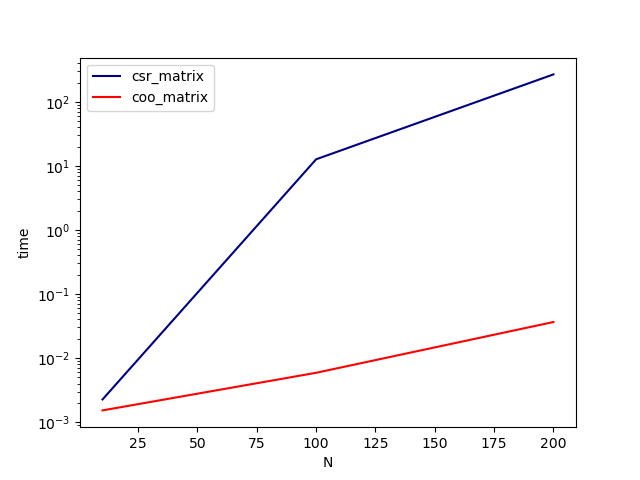

In [11]:
n_values = np.array([10 , 100 ,  200 ])
Hcsr_times = []
Hcoo_times = []

from tqdm import tqdm
for n in tqdm(n_values):
    h = np.arange(3*n**2)
    Hcsr_times.append(H_matrix_csr(n, h))
    Hcoo_times.append(H_matrix_coo(n, h))
fig , ax = plt.subplots()
ax.semilogy(n_values , Hcsr_times , color = 'navy' , label = 'csr_matrix')
ax.semilogy(n_values , Hcoo_times , color = 'r' , label = 'coo_matrix')
ax.set_ylabel('time')
ax.set_xlabel(r'N')
ax.legend()


I couldn't go to $N = 1000$ because my laptop craps its pants! Like the mouse button literally stops working D:

But still, it looks like the speedup is very noteceable- 4 orders of magnitude more noticeable at large N!

#### Rough work and Trouble-Shooting

For generating banded sparse matrices I will need to generate arrays like this:
$$ \vec{r} = (0 ,0 , 1 , 3 , 3 , 4 ... 3N , 3N , 3N+1) $$
$$ \vec{c} = (1 , 2 , 2  , 4 , 5 , 5 , ...  , 3N+1 , 3N+2 , 3N + 2)$$

In [12]:
test = np.arange(33 , step = 3)
testrepeated = np.repeat(test , 3)
print(testrepeated)

monomer1 = np.array([0 , 0 , 1]) # I'm gonna call this a monomer because it is like a repeating unit..
polymer1 = np.tile(monomer1 , 11)
print(polymer1)

r = polymer1 + testrepeated
print(r)

monomer2 = np.array([1 , 2 , 2])
polymer2 = np.tile(monomer2 , 11)

c = polymer2 + testrepeated
print(c)

[ 0  0  0  3  3  3  6  6  6  9  9  9 12 12 12 15 15 15 18 18 18 21 21 21
 24 24 24 27 27 27 30 30 30]
[0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1]
[ 0  0  1  3  3  4  6  6  7  9  9 10 12 12 13 15 15 16 18 18 19 21 21 22
 24 24 25 27 27 28 30 30 31]
[ 1  2  2  4  5  5  7  8  8 10 11 11 13 14 14 16 17 17 19 20 20 22 23 23
 25 26 26 28 29 29 31 32 32]


We also need to do some rearrangements to the $\mathbf{h}$ vector. This is because, it will probably be output in this format:
$$ \mathbf{h} = (h^{x}_{00} , h^{y}_{00} , h^{z}_{00} , ... , h^{x}_{NN} , h^{y}_{NN} , h^{z}_{NN})^{T} $$
where the subscripts give the lattice site coordinate. However, when passing into `coo_matrix` we need it in this form so that the matrix implements a cross product:
$$ \tilde{\mathbf{h}} = (-h^{z}_{00} , h^{y}_{00} , -h^{x}_{00} , ... , -h^{z}_{NN} , h^{y}_{NN} , -h^{x}_{NN})^{T} $$
I think we can achieve this using a simple matrix transformation:
$$\tilde{\mathbf{h}} = \mathcal{A}\mathbf{h} $$

In [13]:
vec = np.array([1 , 2 , 3 , 4 , 5, 6])

block = np.array([[0,0,-1],[0 , 1 , 0],[-1  , 0 , 0]])
blockmatrix = np.kron(np.eye(2) , block)
print(blockmatrix)
print(blockmatrix@vec)


[[ 0.  0. -1.  0.  0. -0.]
 [ 0.  1.  0.  0.  0.  0.]
 [-1.  0.  0. -0.  0.  0.]
 [ 0.  0. -0.  0.  0. -1.]
 [ 0.  0.  0.  0.  1.  0.]
 [-0.  0.  0. -1.  0.  0.]]
[-3.  2. -1. -6.  5. -4.]


Or if we wanted to make something really big we could use the `sparse.kron` function

In [14]:
l = 100
t1 = time.time()
bigeye = sparse.identity(l*l)
t2 = time.time()

t3 = time.time()
sparseblockmatrix = sparse.kron(bigeye , block)
t4 = time.time()

# fig , ax = plt.subplots()
# ax.imshow(sparseblockmatrix.toarray())

In [15]:
print('Sparse identity' , t2 - t1)
print('Sparse kronecker product' , t4 - t3)

Sparse identity 0.00031304359436035156
Sparse kronecker product 0.00337982177734375


I will also need to generate the $\mathbf{h}$ vector be repeatedly calling the `H_eff` function:

In [24]:
h = np.zeros(shape = (6))
print(h[0 : 3])
h[0 : 3] = np.array([0 , 0 , 1])
h[3 : 6] = np.array([1 , 2, 3])
print(h)


[0. 0. 0.]
[0. 0. 1. 1. 2. 3.]


A similar `coo_matrix` optimisation should also be applied to `M_matrix`. $\vec{M}$ is a $1\times3N^2$ array which stores all the magnetisation components in the following way:
$$\vec{M} = (\vec{m}_{00} , \vec{m}_{01} , \vec{m}_{02} , ... , \vec{m}_{NN} ) $$
This means we just have to shuffle it using matrix $\mathcal{A}$ before sparsifying using `coo_matrix`.